In [1]:
# Importing the required libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model


import pennylane as qml
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import gc

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load Dataset
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

# **Model Pre-processing**

In [3]:
# Filter TLS-related traffic
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[(darknet_data['Dst Port'].isin(tls_ports)) & (darknet_data['Protocol'] == 6)]

In [4]:
# Ensure tls_traffic is a separate DataFrame
tls_traffic = tls_traffic.copy()

# Encode categorical data safely
label_encoder = LabelEncoder()
for column in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic[column] = label_encoder.fit_transform(tls_traffic[column])

# Save Label Encoder for Flask
joblib.dump(label_encoder, "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\label_encoder.pkl")


['E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\label_encoder.pkl']

In [5]:
# Ensure tls_traffic is a separate DataFrame
tls_traffic = tls_traffic.copy()

# Select Numeric Columns
columns_to_exclude = ['Protocol', 'Dst Port', 'Label']
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Optimize Memory
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].astype(np.float32)
gc.collect()

20

In [6]:
# Ensure tls_traffic is a separate DataFrame to avoid modifying a view
tls_traffic = tls_traffic.copy()

# Handle Missing & Extreme Values
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].clip(
    lower=tls_traffic[numeric_columns].quantile(0.01),
    upper=tls_traffic[numeric_columns].quantile(0.99),
    axis=1
)

# Apply MinMax Scaling
scaler = MinMaxScaler()
tls_traffic[numeric_columns] = scaler.fit_transform(tls_traffic[numeric_columns])

# Save Scaler for Flask
joblib.dump(scaler, "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\scaler.pkl")

['E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\scaler.pkl']

# **Feature Selection and Feature Importance**

Timestamp feature removed after feature selection!
Selected Features Based on Correlation with 'Label':
['Total Bwd packets', 'Bwd Packet Length Min', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min']


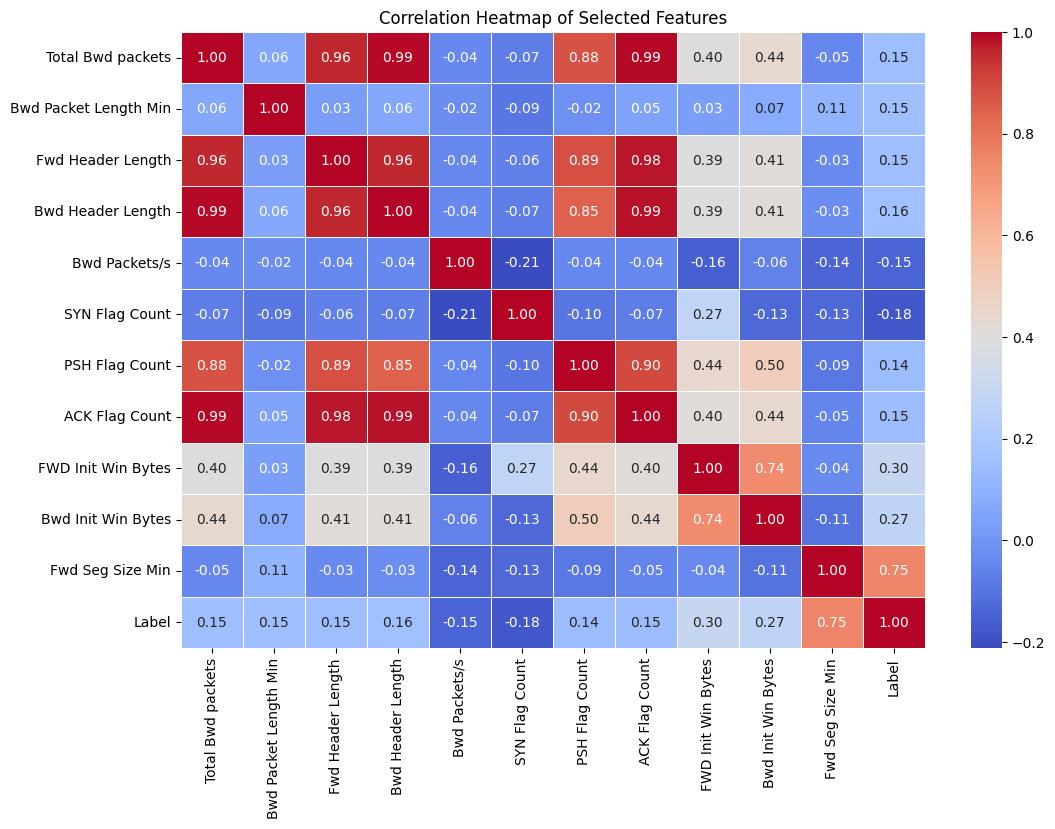

Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'


In [7]:
# Feature Selection Process (Newly Added)
correlation_matrix = tls_traffic.corr(numeric_only=True)
target_correlation = correlation_matrix['Label'].drop('Label')
threshold = 0.14  # Selecting features with absolute correlation > 0.14
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns if they exist
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

# Keep only the selected features and the Label
tls_traffic = tls_traffic[selected_features.index.tolist() + ['Label']]
if 'Timestamp' in tls_traffic.columns:
    tls_traffic = tls_traffic.drop(columns=['Timestamp'])
    print("Timestamp feature removed after feature selection!")

selected_features_list = selected_features.index.tolist()
if 'Timestamp' in selected_features_list:
    selected_features_list.remove('Timestamp')

print("Selected Features Based on Correlation with 'Label':")
print(selected_features_list)

joblib.dump(selected_features_list, "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\selected_features.pkl")

# Generate correlation heatmap for the selected features
plt.figure(figsize=(12, 8))
sns.heatmap(tls_traffic.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

tls_traffic.to_csv("4. Feature_Selected_Dataset_Without_Identifiers.csv", index=False)
print("Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'")

In [8]:
# Apply SMOTE to handle class imbalance
X = tls_traffic.drop('Label', axis=1)
y = tls_traffic['Label']
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)
tls_traffic = pd.DataFrame(X, columns=X.columns)
tls_traffic['Label'] = y
gc.collect()

joblib.dump(smote, "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\smote.pkl")

['E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\smote.pkl']

In [9]:
# One-Hot Encode the 'Label' column
ohe = OneHotEncoder(sparse_output=False)  # Use dense output instead of sparse matrix
y_encoded = ohe.fit_transform(tls_traffic[['Label']])  # Encode the label column

# Convert to DataFrame with proper column names
ohe_columns = [f"Class_{i}" for i in range(y_encoded.shape[1])]
y_encoded_df = pd.DataFrame(y_encoded, columns=ohe_columns)

# Keep original 'Label' column while adding one-hot encoded versions
tls_traffic = pd.concat([tls_traffic, y_encoded_df], axis=1)

joblib.dump(ohe, "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\ohe.pkl")

['E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\ohe.pkl']

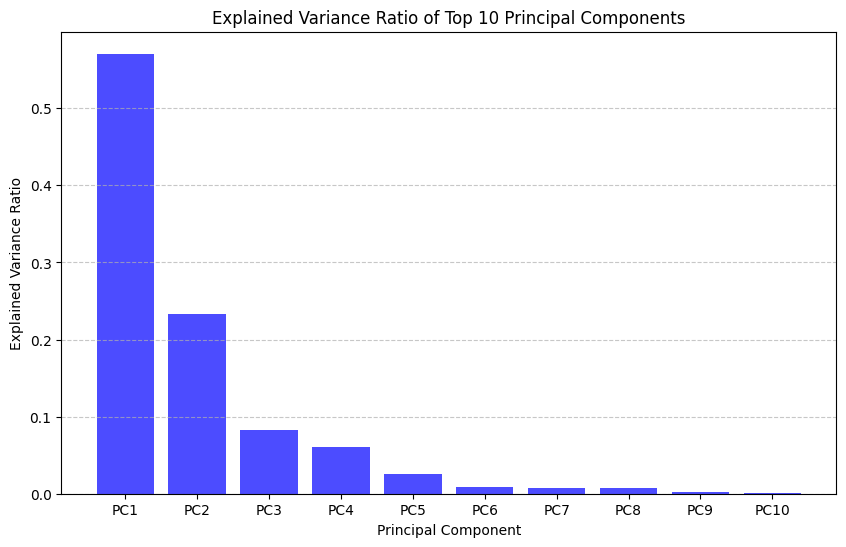

In [10]:
# Apply PCA
pca = PCA(n_components=10)  # Select the top 10 principal components
X_pca = pca.fit_transform(X)  # Fit PCA on the dataset

# Convert to DataFrame with proper column names
X_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(10)])

joblib.dump(pca, "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\pca.pkl")

# Generate the explained variance ratio plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.7, color="blue")
plt.xticks(range(1, 11), [f"PC{i}" for i in range(1, 11)])
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.title("Explained Variance Ratio of Top 10 Principal Components")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [11]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# **Quantum Device and Quantum Circuit Intialization**

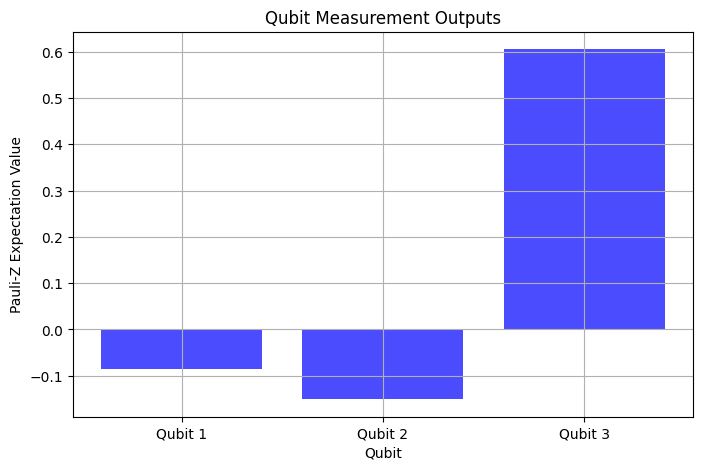

In [12]:
# Split for quantum & classical inputs
num_qubits = 3

# First 3 features for Quantum
quantum_features = X_train.iloc[:, :num_qubits]  

# Remaining for Classical features alone
classical_features = X_train.iloc[:, num_qubits:]  

# Define Quantum Circuit
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Define Sample Input (Quantum Features)
sample_input = np.array([0.5, 0.2, -0.3])  # Example input for 3 qubits

# Define Sample Weights (Required for StronglyEntanglingLayers)
num_layers = 2  # Define the number of layers for entanglement
sample_weights = np.random.randn(num_layers, num_qubits, 3)

# Run the circuit to get expectation values
expectation_values = quantum_circuit(sample_input, sample_weights)

# Plot expectation values
plt.figure(figsize=(8, 5))
plt.bar(range(len(expectation_values)), expectation_values, color="blue", alpha=0.7)
plt.xlabel("Qubit")
plt.ylabel("Pauli-Z Expectation Value")
plt.title("Qubit Measurement Outputs")
plt.xticks(range(len(expectation_values)), [f"Qubit {i+1}" for i in range(len(expectation_values))])
plt.grid()
plt.show()

# **Hybrid Quantum-Classical Neural Network**

In [13]:
# Define Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(name="q_weights", shape=(1, num_qubits), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        return tf.random.uniform((tf.shape(inputs)[0], self.num_qubits))

    def get_config(self):
        config = super().get_config()
        config.update({"num_qubits": self.num_qubits})
        return config

# Define Hybrid Model
def create_hybrid_model(num_qubits, num_features, num_classes=4):
    input_q = tf.keras.layers.Input(shape=(num_qubits,))
    input_c = tf.keras.layers.Input(shape=(num_features - num_qubits,))
    
    # Quantum Path
    q_layer = QuantumLayer(num_qubits)(input_q)
    q_layer = tf.keras.layers.Dense(32, activation="relu")(q_layer)

    # Classical Path
    # Reduce neurons & increase dropout
    c_layer = tf.keras.layers.Dense(64, activation="relu")(input_c)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.3)(c_layer)
    c_layer = tf.keras.layers.Dense(32, activation="relu")(c_layer)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.3)(c_layer)

    
    # Fusion of Quantum & Classical Features
    combined = tf.keras.layers.concatenate([q_layer, c_layer])
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(combined)

    model = tf.keras.models.Model(inputs=[input_q, input_c], outputs=output)
    return model

In [14]:
hybrid_model = create_hybrid_model(num_qubits, X_train.shape[1])
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss="categorical_crossentropy",
                     metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [15]:
# Split Training & Validation Data
X_train_q, X_val_q, X_train_c, X_val_c, y_train_split, y_val_split = train_test_split(
    quantum_features, classical_features, to_categorical(y_train, num_classes=4),
    test_size=0.2, random_state=42, stratify=y_train
)

In [16]:
# Define Custom Data Generator
class CustomBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_q, X_c, y, batch_size):
        self.X_q = X_q
        self.X_c = X_c
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_X_q = self.X_q[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_c = self.X_c[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X_q, batch_X_c], batch_y

train_generator = CustomBatchGenerator(X_train_q, X_train_c, y_train_split, batch_size=32)
val_generator = CustomBatchGenerator(X_val_q, X_val_c, y_val_split, batch_size=32)

In [17]:
# Train the Model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=1
)

Epoch 1/100
912/912 [==============================] - 2s 1ms/step - loss: 0.3731 - accuracy: 0.8769 - precision: 0.9096 - recall: 0.8398 - val_loss: 0.0811 - val_accuracy: 0.9782 - val_precision: 0.9812 - val_recall: 0.9757
Epoch 2/100
912/912 [==============================] - 1s 1ms/step - loss: 0.1331 - accuracy: 0.9581 - precision: 0.9636 - recall: 0.9537 - val_loss: 0.0435 - val_accuracy: 0.9844 - val_precision: 0.9863 - val_recall: 0.9842
Epoch 3/100
912/912 [==============================] - 1s 1ms/step - loss: 0.0845 - accuracy: 0.9735 - precision: 0.9755 - recall: 0.9713 - val_loss: 0.0216 - val_accuracy: 0.9945 - val_precision: 0.9945 - val_recall: 0.9933
Epoch 4/100
912/912 [==============================] - 1s 1ms/step - loss: 0.0663 - accuracy: 0.9781 - precision: 0.9801 - recall: 0.9762 - val_loss: 0.0102 - val_accuracy: 0.9975 - val_precision: 0.9977 - val_recall: 0.9963
Epoch 5/100
912/912 [==============================] - 1s 1ms/step - loss: 0.0558 - accuracy: 0.9813

In [18]:
# Save the trained Hybrid Quantum-Classical Model
hybrid_model.save("E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\hybrid_qnn_model.h5")
print("Hybrid QNN Model saved successfully as 'hybrid_qnn_model.h5'.")

Hybrid QNN Model saved successfully as 'hybrid_qnn_model.h5'.


In [19]:
# Predict Malicious TLS Traffic
y_pred_probs = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]])
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract Malicious Traffic
malicious_traffic = X_test.iloc[np.where(y_pred == 0)].copy()
malicious_traffic['Predicted_Label'] = y_pred[np.where(y_pred == 0)]

# Save Malicious TLS Traffic to CSV
malicious_traffic.to_csv("E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\Malicious_TLS_Traffic.csv", index=False)
print(f"Saved {len(malicious_traffic)} malicious TLS traffic records to 'Malicious_TLS_Traffic.csv'.")

285/285 [==============================] - 0s 533us/step
Saved 2279 malicious TLS traffic records to 'Malicious_TLS_Traffic.csv'.


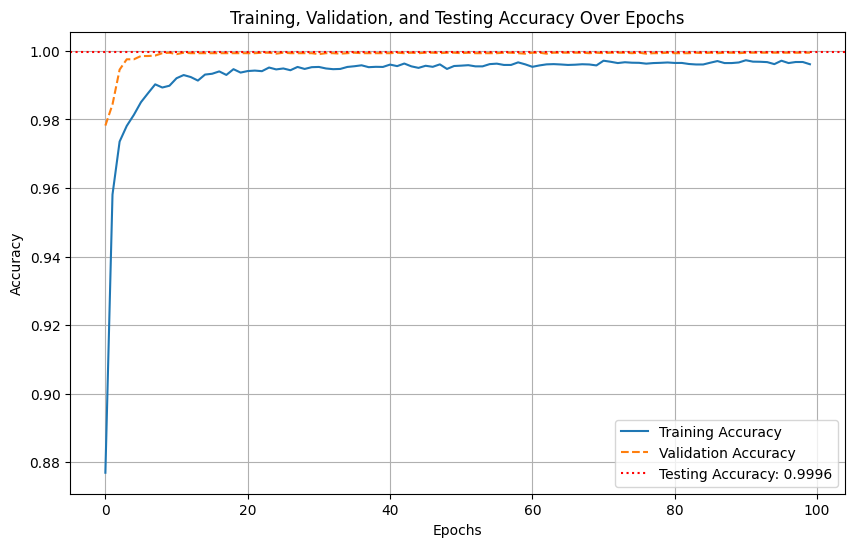

In [20]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='solid')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')

# Calculate Testing Accuracy
test_accuracy = np.mean(y_pred == y_test)
plt.axhline(y=test_accuracy, color='r', linestyle='dotted', label=f'Testing Accuracy: {test_accuracy:.4f}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Testing Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute MSE for training and validation
train_mse = history.history['loss']  # Training MSE (loss)
val_mse = history.history['val_loss']  # Validation MSE (loss)

# Convert to RMSE
train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)

# Predictions on train, validation, and test sets
y_train_pred = hybrid_model.predict([X_train_q, X_train_c]).argmax(axis=1)
y_val_pred = hybrid_model.predict([X_val_q, X_val_c]).argmax(axis=1)
y_test_pred = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]]).argmax(axis=1)

# Compute single-value MSE, RMSE, and R² for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Compute R² for training and validation
train_r2 = r2_score(y_train_split.argmax(axis=1), y_train_pred)
val_r2 = r2_score(y_val_split.argmax(axis=1), y_val_pred)


285/285 [==============================] - 0s 567us/step



=== Model Performance Metrics ===
Final Training MSE: 0.0124
Final Validation MSE: 0.0036
Final Testing MSE: 0.0004 

Final Training RMSE: 0.1114
Final Validation RMSE: 0.0601
Final Testing RMSE: 0.0209 

Final Training R² Score: 0.9993
Final Validation R² Score: 0.9996
Final Testing R² Score: 0.9996 



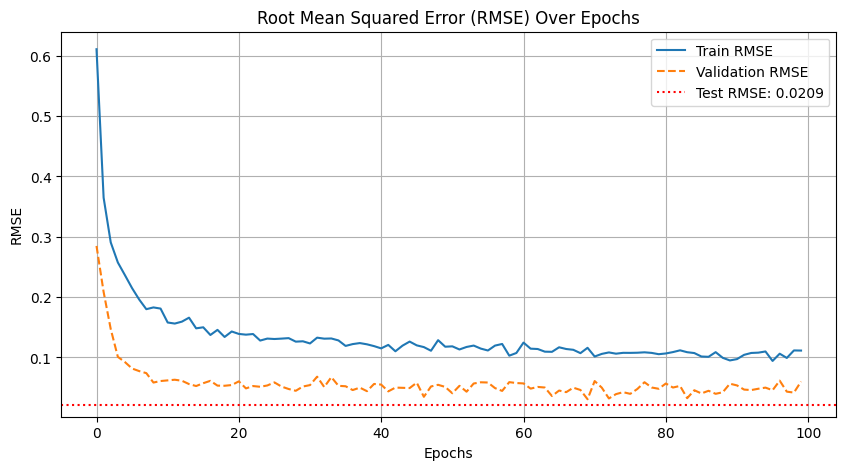

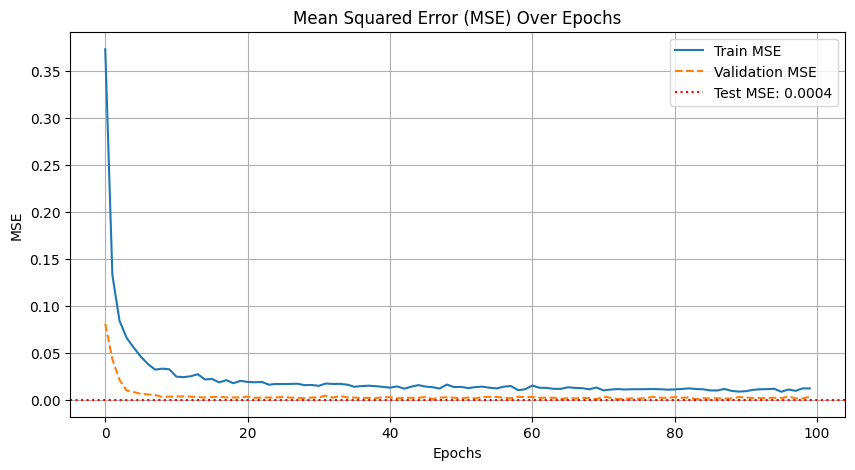

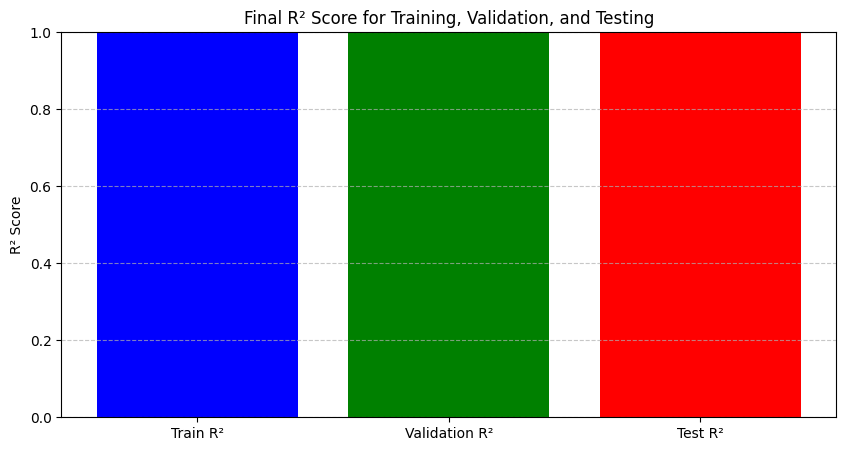

In [34]:
# Print Exact RMSE, MSE, and R² values for Train, Validation, and Test
print("\n=== Model Performance Metrics ===")
print(f"Final Training MSE: {train_mse[-1]:.4f}")
print(f"Final Validation MSE: {val_mse[-1]:.4f}")
print(f"Final Testing MSE: {test_mse:.4f} \n")

print(f"Final Training RMSE: {train_rmse[-1]:.4f}")
print(f"Final Validation RMSE: {val_rmse[-1]:.4f}")
print(f"Final Testing RMSE: {test_rmse:.4f} \n")

print(f"Final Training R² Score: {train_r2:.4f}")
print(f"Final Validation R² Score: {val_r2:.4f}")
print(f"Final Testing R² Score: {test_r2:.4f} \n")

# Plot RMSE Curve
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE', linestyle='solid')
plt.plot(val_rmse, label='Validation RMSE', linestyle='dashed')
plt.axhline(y=test_rmse, color='r', linestyle='dotted', label=f'Test RMSE: {test_rmse:.4f}')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot MSE Curve
plt.figure(figsize=(10, 5))
plt.plot(train_mse, label='Train MSE', linestyle='solid')
plt.plot(val_mse, label='Validation MSE', linestyle='dashed')
plt.axhline(y=test_mse, color='r', linestyle='dotted', label=f'Test MSE: {test_mse:.4f}')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot R² Score for Training, Validation, and Testing
plt.figure(figsize=(10, 5))
plt.bar(["Train R²", "Validation R²", "Test R²"], [train_r2, val_r2, test_r2], color=["blue", "green", "red"])
plt.ylabel("R² Score")
plt.title("Final R² Score for Training, Validation, and Testing")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

285/285 [==============================] - 0s 570us/step


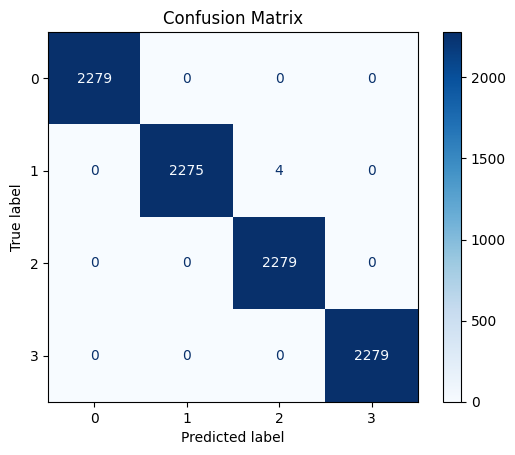

In [21]:
# Predict labels for the test set
y_pred = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]])
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.array(y_test)  # True labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

# Shuffle dataset before selecting a random sample
tls_traffic = tls_traffic.sample(frac=1).reset_index(drop=True)

# Identify label columns (Both One-Hot Encoded and Original)
label_columns = [col for col in tls_traffic.columns if "Class_" in col]
original_label_column = "Label" if "Label" in tls_traffic.columns else None

# Load a Truly Random TLS Traffic Sample
random_sample = tls_traffic.sample(1).copy()

# Extract the true label
true_label = random_sample[original_label_column].values[0]

# Drop One-Hot Encoded label columns but KEEP original Label
random_sample = random_sample.drop(columns=label_columns)

# Ensure Feature Alignment
random_sample = random_sample.reindex(columns=X.columns, fill_value=0)

# Apply the Same Preprocessing as Training Data
scaler = MinMaxScaler().fit(X)
random_sample_scaled = scaler.transform(random_sample)

# Apply PCA
random_sample_pca = pd.DataFrame(
    pca.transform(random_sample_scaled),
    columns=[f"PCA_{i+1}" for i in range(pca.n_components_)]
)

# Split into Quantum & Classical Inputs
random_sample_q = random_sample_pca.iloc[:, :num_qubits].values
random_sample_c = random_sample_pca.iloc[:, num_qubits:].values

# Display DataFrames Neatly
def display_dataframe(title, df):
    print(f"\n===== {title} =====")
    display(df.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ))

# Show Tables in a Clean Format
display_dataframe("Random TLS Traffic Sample (Before Processing)", random_sample)
display_dataframe("Random TLS Traffic Sample (After Scaling)", pd.DataFrame(random_sample_scaled, columns=X.columns))
display_dataframe("Random TLS Traffic Sample (After PCA)", random_sample_pca)
display_dataframe("Quantum Features Passed to Model", pd.DataFrame(random_sample_q, columns=[f"Q_{i+1}" for i in range(num_qubits)]))
display_dataframe("Classical Features Passed to Model", pd.DataFrame(random_sample_c, columns=[f"C_{i+1}" for i in range(random_sample_c.shape[1])]))

# Predict Using the Model
pred_prob = hybrid_model.predict([random_sample_q, random_sample_c])
pred_label = np.argmax(pred_prob, axis=1)[0]

# Define Labels
labels_dict = {0: "Malicious", 1: "Non-Malicious", 2: "Uncertain"}

# Display Prediction Result
print("\n===== Random TLS Traffic Prediction =====")
print(f"Predicted Label: {labels_dict[pred_label]}")
print(f"True Label: {'Malicious' if true_label == 0 else 'Non-Malicious'}")

c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(



===== Random TLS Traffic Sample (Before Processing) =====


,Total Bwd packets,Bwd Packet Length Min,Fwd Header Length,Bwd Header Length,Bwd Packets/s,SYN Flag Count,PSH Flag Count,ACK Flag Count,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Seg Size Min,Label
38686,0.002782,0.000000,0.002676,0.002493,0.001841,1.000000,0.003978,0.002699,0.220056,1.000000,0.000000,2



===== Random TLS Traffic Sample (After Scaling) =====


,Total Bwd packets,Bwd Packet Length Min,Fwd Header Length,Bwd Header Length,Bwd Packets/s,SYN Flag Count,PSH Flag Count,ACK Flag Count,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Seg Size Min,Label
0,0.002782,0.000000,0.002676,0.002493,0.001841,1.000000,0.003978,0.002699,0.220056,1.000000,0.000000,0.666667



===== Random TLS Traffic Sample (After PCA) =====


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-0.910551,0.333250,0.647729,-0.353030,0.166696,0.661885,-0.057135,-0.032530,0.018845,0.010493



===== Quantum Features Passed to Model =====


,Q_1,Q_2,Q_3
0,-0.910551,0.333250,0.647729



===== Classical Features Passed to Model =====


,C_1,C_2,C_3,C_4,C_5,C_6,C_7
0,-0.353030,0.166696,0.661885,-0.057135,-0.032530,0.018845,0.010493


1/1 [==============================] - 0s 64ms/step

===== Random TLS Traffic Prediction =====
Predicted Label: Non-Malicious
True Label: Non-Malicious


In [23]:
# Load the saved model
loaded_hybrid_model = load_model("hybrid_qnn_model.h5", custom_objects={"QuantumLayer": QuantumLayer})

# Verify the loaded model summary
loaded_hybrid_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 64)           512         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64)          256         ['dense_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['batch_normalization[0][0]']